In [1]:
import pandas as pd
import numpy as np
import arxiv
import os
import networkx as nx
import itertools
from top2vec import Top2Vec

/opt/miniconda3/envs/arxiv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client=arxiv.Client()

In [3]:
search = arxiv.Search(
  query = "misinformation",
  max_results = 100000,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

In [4]:
results=client.results(search)

In [5]:
all_results = list(results)

In [6]:
len(all_results)

1570

In [7]:
all_results[0]

arxiv.Result(entry_id='http://arxiv.org/abs/2411.01794v1', updated=datetime.datetime(2024, 11, 4, 4, 34, 29, tzinfo=datetime.timezone.utc), published=datetime.datetime(2024, 11, 4, 4, 34, 29, tzinfo=datetime.timezone.utc), title='Revisiting Game-Theoretic Control in Socio-Technical Networks: Emerging Design Frameworks and Contemporary Applications', authors=[arxiv.Result.Author('Quanyan Zhu'), arxiv.Result.Author('Tamer Başar')], summary='Socio-technical networks represent emerging cyber-physical infrastructures\nthat are tightly interwoven with human networks. The coupling between human and\ntechnical networks presents significant challenges in managing, controlling,\nand securing these complex, interdependent systems. This paper investigates\ngame-theoretic frameworks for the design and control of socio-technical\nnetworks, with a focus on critical applications such as misinformation\nmanagement, infrastructure optimization, and resilience in socio-cyber-physical\nsystems (SCPS). Cor

In [8]:
authorship=[]
for authors in all_results:
    author_list=[]
    for i in authors.authors:
        author_list.append(i.name)
    authorship.append(author_list)

In [9]:
authorship[0]

['Quanyan Zhu', 'Tamer Başar']

In [10]:
abstract=[]
for abstracts in all_results:
    abstract.append(abstracts.summary)

In [11]:
len(abstract)

1570

In [12]:
G=nx.Graph()

In [13]:
edges=[]
for val in authorship:
    edges.extend(list(itertools.combinations(val, 2)))

In [14]:
G.add_edges_from(edges)

In [15]:
len(list(G.nodes))

4863

In [16]:
sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('Preslav Nakov', 0.019950637597696424),
 ('Iason Gabriel', 0.014191690662278898),
 ('Lisa Anne Hendricks', 0.014191690662278898),
 ('Sasha Brown', 0.014191690662278898),
 ('Conor Griffin', 0.014191690662278898)]

In [17]:
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')

In [18]:
average_degree_centrality = np.mean(list(nx.degree_centrality(G).values()))

In [19]:
nodes_to_remove = [node for node, centrality in nx.degree_centrality(G).items() if centrality < average_degree_centrality]
G.remove_nodes_from(nodes_to_remove)

In [20]:
len(list(G.nodes()))

1406

In [21]:
pos=nx.kamada_kawai_layout(G)

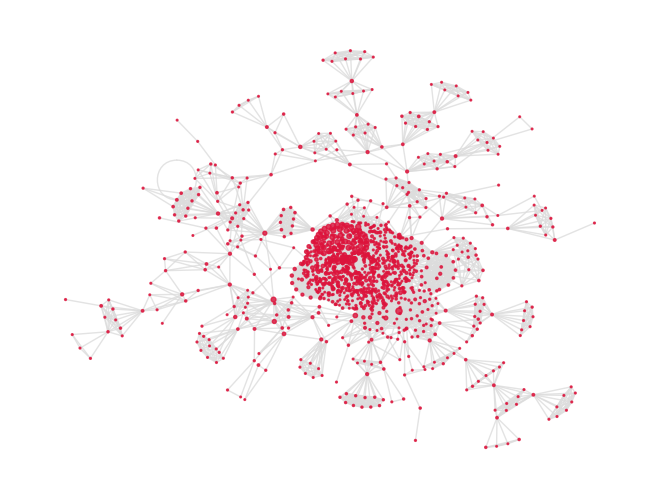

In [22]:
degree=nx.get_node_attributes(G, 'degree')
node_size=[v * 1000 for v in degree.values()]  
nx.draw(G, pos=pos, node_size=node_size, node_color='crimson', edge_color='gainsboro', alpha=0.8)

In [70]:
nx.average_clustering(G)

0.8949979686948214

In [23]:
G.nodes['Preslav Nakov']

{'degree': 0.019950637597696424}

In [24]:
sorted_nodes=sorted(G.nodes(data=True), key=lambda x: x[1].get('degree', 0), reverse=True)
sorted_nodes[:5]

[('Preslav Nakov', {'degree': 0.019950637597696424}),
 ('Iason Gabriel', {'degree': 0.014191690662278898}),
 ('Lisa Anne Hendricks', {'degree': 0.014191690662278898}),
 ('Sasha Brown', {'degree': 0.014191690662278898}),
 ('Conor Griffin', {'degree': 0.014191690662278898})]

In [25]:
model=Top2Vec(abstract)
#25s

2024-11-06 13:48:27,382 - top2vec - INFO - Pre-processing documents for training
/opt/miniconda3/envs/arxiv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-11-06 13:48:27,772 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2024-11-06 13:48:42,713 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-11-06 13:48:47,365 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-11-06 13:48:51,951 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-11-06 13:48:51,981 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [40]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [41]:
len(topic_nums)

14

In [44]:
id_dic={}
topic_id={}
for element in zip(topic_nums, topic_sizes):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=element[0], num_docs=element[1])
    for score, id in zip(document_scores, document_ids):
        id_dic[id]=score
        topic_id[id]=element[0]

In [45]:
topic_words, word_scores, topic_scores = model.get_topics(len(topic_sizes))

In [46]:
df_words=pd.DataFrame(topic_words).transpose()
df_words.columns=topic_nums
df_words.columns = df_words.columns.astype(str)

In [50]:
df_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,information,datasets,networks,impacts,news,infodemic,llms,datasets,multilingual,artificial,twitter,deepfakes,vaccines,bots
1,misinformation,dataset,algorithms,misinformation,credible,epidemic,datasets,algorithms,languages,technologies,tweets,deepfake,vaccine,bot
2,disinformation,credible,distribution,media,sources,misinformation,llm,models,datasets,intelligence,elections,detectors,vaccination,automated
3,datasets,data,algorithm,influence,propaganda,disinformation,dataset,generative,dataset,ethical,election,fake,epidemic,twitter
4,data,evidence,network,impact,disinformation,information,methodology,representations,linguistic,technology,impacts,algorithms,viral,datasets
5,infodemic,sources,methodology,disinformation,credibility,datasets,multilingual,dataset,language,generative,influence,detection,propaganda,tweets
6,impacts,methodology,datasets,communities,misinformation,dataset,sources,deepfakes,data,automated,propaganda,detecting,spread,effectiveness
7,media,reliability,dataset,users,media,media,multimodal,detection,disinformation,risks,media,technologies,population,artificial
8,dataset,information,nodes,propaganda,fake,data,reliability,methodology,information,vulnerable,political,technology,disinformation,algorithms
9,impact,factual,computational,information,information,viral,resource,technologies,accuracy,implications,campaigns,techniques,spreading,dataset


In [67]:
df = pd.DataFrame({'abstract': abstract, 'authorship': authorship})
df.head()

,abstract,authorship
0,Socio-technical networks represent emerging cy...,"[Quanyan Zhu, Tamer Başar]"
1,With the advent of social media networks and t...,"[Chathuri Jayaweera, Sangpil Youm, Bonnie Dorr]"
2,Narratives are key interpretative devices by w...,"[Armin Pournaki, Tom Willaert]"
3,Retrieval-augmented generation methods often n...,"[Yun Jiang, Zilong Xie, Wei Zhang, Yun Fang, S..."
4,"In this paper, we introduce the first release ...","[Ashwin Balasubramanian, Vito Zou, Hitesh Nara..."


In [68]:
df['topic_id']=df.index.map(topic_id) #map topic id to each document
df['topic_score']=df.index.map(id_dic) #map topic score to each document

In [69]:
df

,abstract,authorship,topic_id,topic_score
0,Socio-technical networks represent emerging cy...,"[Quanyan Zhu, Tamer Başar]",2,0.598290
1,With the advent of social media networks and t...,"[Chathuri Jayaweera, Sangpil Youm, Bonnie Dorr]",1,0.711577
2,Narratives are key interpretative devices by w...,"[Armin Pournaki, Tom Willaert]",0,0.580862
3,Retrieval-augmented generation methods often n...,"[Yun Jiang, Zilong Xie, Wei Zhang, Yun Fang, S...",1,0.703117
4,"In this paper, we introduce the first release ...","[Ashwin Balasubramanian, Vito Zou, Hitesh Nara...",10,0.638456
...,...,...,...,...
1565,We consider a simple modal logic whose non-mod...,"[Mehrnoosh Sadrzadeh, Roy Dyckhoff]",2,0.484828
1566,We show in detail that the Hawking temperature...,"[S. Habib Mazharimousavi, I. Sakalli, M. Halil...",2,0.345275
1567,Even professional baseball players occasionall...,"[Michael K. McBeath, Alan M. Nathan, A. Terry ...",2,0.237078
1568,Interpretation of cosmological data to determi...,"[Eric V. Linder, Ramon Miquel]",1,0.539339
